<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_4_Machine_Learning_Models_(Simplified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pmdarima

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# ============================================================
# CELL 1: SETUP AND DATA SPLITTING (WITH BASIC FEATURE ENGINEERING, DROP MARKET)
# ============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

!pip install holidays

# Imports for basic features
import holidays
from datetime import date

# Load the base data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls'

# Use TimeSeriesSplit to create a final hold-out set (the last 20% of the data)
print("Splitting data into training/validation and a final hold-out test set...")
tscv_split = TimeSeriesSplit(n_splits=5)
all_splits = list(tscv_split.split(df))
train_val_idx, test_idx = all_splits[-1]

df_train_val = df.iloc[train_val_idx]
df_test = df.iloc[test_idx]

print(f"Training/Validation set size: {len(df_train_val)} records")
print(f"Hold-out test set size: {len(df_test)} records")

# Simplified feature engineering function
def add_basic_time_features(df, target_col='calls'):
    df = df.copy()

    # 1. Basic Trend (simple index)
    df['time_index'] = np.arange(len(df))
    df['trend_simple'] = df['time_index']

    # 2. Basic Holidays (binary only)
    min_year = df.index.min().year
    max_year = df.index.max().year
    us_holidays = holidays.US(years=range(min_year, max_year + 1))
    holiday_dates = list(us_holidays.keys())
    df['is_holiday'] = df.index.map(lambda x: 1 if x.date() in holiday_dates else 0)

    # 3. Minimal Lags/Rollings (weekly only)
    df[f'{target_col}_lag_7'] = df[target_col].shift(7)
    df[f'{target_col}_roll_mean_7'] = df[target_col].rolling(7).mean().shift(1)

    # Drop NaNs (or fill if too many drops)
    df = df.dropna().fillna(0)  # Simplified handling

    return df

# Apply separately
print("Adding basic time features...")
df_train_val = add_basic_time_features(df_train_val)
df_test = add_basic_time_features(df_test)

# Update splits, dropping market features
exclude_market = ['^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume', 'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close', 'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume']  # Financial columns
features = [col for col in df_train_val.columns if col != target and col not in exclude_market]
X_train_val = df_train_val[features]
y_train_val = df_train_val[target]
X_test = df_test[features]
y_test = df_test[target]

print("Market features dropped; basic features added and data prepared.")

Splitting data into training/validation and a final hold-out test set...
Training/Validation set size: 815 records
Hold-out test set size: 163 records
Adding basic time features...
Market features dropped; basic features added and data prepared.


In [2]:
# ============================================================
# CELL 2: VERIFY DATA LOADING AND FEATURE FILTERING
# ============================================================

print("Data loaded and basic features added successfully.")

# Show full DataFrame head (includes all columns, including market for reference)
print("\nFull df_train_val head (market columns present here, but filtered out for modeling):")
display(df_train_val.head())

# Verify filtered features (market excluded)
print("\nFiltered features for modeling (market columns excluded):")
print(features)

# Show X_train_val head (should exclude market columns)
print("\nX_train_val head (filtered, no market columns):")
display(X_train_val.head())

Data loaded and basic features added successfully.

Full df_train_val head (market columns present here, but filtered out for modeling):


,calls,^VIX_close,SPY_close,SPY_volume,QQQ_close,QQQ_volume,DX-Y.NYB_close,GC=F_close,GC=F_volume,BTC-USD_close,...,Month,Quarter,DayOfWeek,Year,outlier_multivariate,time_index,trend_simple,is_holiday,calls_lag_7,calls_roll_mean_7
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-08,4410,21.129999,375.187500,104189600.0,264.686096,54659700.0,103.879997,1864.199951,26.0,17091.144531,...,1,1,6,2023,False,7,7,0,2882.0,5824.000000
2023-01-09,7166,21.969999,374.974762,73978100.0,266.399445,45568700.0,103.000000,1872.699951,62.0,17196.554688,...,1,1,0,2023,False,8,8,0,5055.0,6042.285714
2023-01-10,7381,20.580000,377.604370,65358100.0,268.654419,35247800.0,103.239998,1871.599976,101.0,17446.292969,...,1,1,1,2023,False,9,9,0,6537.0,6343.857143
2023-01-11,7215,21.090000,382.380341,68881100.0,273.302185,44077000.0,103.190002,1874.599976,1236.0,17934.896484,...,1,1,2,2023,False,10,10,0,7238.0,6464.428571
2023-01-12,7652,18.830000,383.772461,90157700.0,274.779144,60600000.0,102.250000,1895.500000,59.0,18869.587891,...,1,1,3,2023,False,11,11,0,7302.0,6461.142857



Filtered features for modeling (market columns excluded):
['is_weekend', 'Month', 'Quarter', 'DayOfWeek', 'Year', 'outlier_multivariate', 'time_index', 'trend_simple', 'is_holiday', 'calls_lag_7', 'calls_roll_mean_7']

X_train_val head (filtered, no market columns):


,is_weekend,Month,Quarter,DayOfWeek,Year,outlier_multivariate,time_index,trend_simple,is_holiday,calls_lag_7,calls_roll_mean_7
Date,,,,,,,,,,,
2023-01-08,True,1,1,6,2023,False,7,7,0,2882.0,5824.000000
2023-01-09,False,1,1,0,2023,False,8,8,0,5055.0,6042.285714
2023-01-10,False,1,1,1,2023,False,9,9,0,6537.0,6343.857143
2023-01-11,False,1,1,2,2023,False,10,10,0,7238.0,6464.428571
2023-01-12,False,1,1,3,2023,False,11,11,0,7302.0,6461.142857


In [3]:
# ============================================================
# CELL: DEFINE DISPLAY_CHAMPION_REPORT FUNCTION (WITH LOGGING AND NAN FIX)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # New: Clean residuals for tests (handle inf/nan, ensure enough points)
    residuals = residuals.replace([np.inf, -np.inf], np.nan).dropna()
    if len(residuals) < 3:
        print("Too few valid residuals for statistical tests—skipping.")
        shapiro_p = np.nan
        lb_pvalue = np.nan
    else:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        lb_test = acorr_ljungbox(residuals, lags=[min(10, len(residuals)-2)], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0] if not lb_test.empty else np.nan

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"ð��� CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("ð��� OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RÂ²:   {r2:.3f}\n")

    # Residual Diagnostics (using cleaned residuals)
    print("ð��� RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}")
    print(f"   {'â�� Residuals appear normal' if shapiro_p > 0.05 else 'â�� Residuals do NOT appear normal'}\n")
    lb_format = f"{lb_pvalue:.4f}" if not np.isnan(lb_pvalue) else 'nan'
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_format}")
    print(f"   {'â�� Residuals appear independent' if (lb_pvalue > 0.05 if not np.isnan(lb_pvalue) else False) else 'â�� Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

    # Log report for tracking
    with open('champion_report.txt', 'a') as f:
        f.write(f"\nChampion: {champion_name}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.3f}\nShapiro p: {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}\nLjung-Box p: {lb_pvalue:.4f if not np.isnan(lb_pvalue) else 'nan'}\n")
    print("Report logged to 'champion_report.txt'.")

In [4]:
# ============================================================
# CELL: DEFINE DISPLAY_CHAMPION_REPORT FUNCTION (WITH LOGGING AND NAN FIX)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # New: Clean residuals for tests (handle inf/nan, ensure enough points)
    residuals = residuals.replace([np.inf, -np.inf], np.nan).dropna()
    if len(residuals) < 3:
        print("Too few valid residuals for statistical tests—skipping.")
        shapiro_p = np.nan
        lb_pvalue = np.nan
    else:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        lb_test = acorr_ljungbox(residuals, lags=[min(10, len(residuals)-2)], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0] if not lb_test.empty else np.nan

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"ð��� CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("ð��� OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RÂ²:   {r2:.3f}\n")

    # Residual Diagnostics (using cleaned residuals)
    print("ð��� RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}")
    print(f"   {'â�� Residuals appear normal' if shapiro_p > 0.05 else 'â�� Residuals do NOT appear normal'}\n")
    lb_format = f"{lb_pvalue:.4f}" if not np.isnan(lb_pvalue) else 'nan'
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_format}")
    print(f"   {'â�� Residuals appear independent' if (lb_pvalue > 0.05 if not np.isnan(lb_pvalue) else False) else 'â�� Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

    # Log report for tracking
    with open('champion_report.txt', 'a') as f:
        f.write(f"\nChampion: {champion_name}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.3f}\nShapiro p: {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}\nLjung-Box p: {lb_pvalue:.4f if not np.isnan(lb_pvalue) else 'nan'}\n")
    print("Report logged to 'champion_report.txt'.")

## Refined Results Interpretation and Next Steps

After running the refined training cell, review the reports:

### Naive Baseline (Weekly Mean)
- **Purpose**: Benchmark—if models don't beat this (e.g., MAE <1500), data may lack predictability.
- **Key**: If Ljung-Box <0.05, confirms need for time-series models.

### Refined Simple SARIMA (Log)
- **Performance**: Aim for MAE <800, R² >0.7, MAPE <12%. Better than before? (Manual orders/clipping should fix nans and stability.)
- **Residuals**: Ljung-Box >0.05 (autocorrelation fixed)? Shapiro >0.05 (normality)? Mean ~0 (bias)?
- **If Improved**: This is your go-to—simple and effective.

### Prophet Simple
- **Performance**: Often shines with holidays; expect MAE ~700-900, R² ~0.7 if data has strong seasonality.
- **Residuals**: Check p-values—Prophet handles trends well, potentially better Shapiro/Ljung-Box.
- **Advantages**: Built-in holidays; easy to add regressors (e.g., market features) if needed.

### Overall Assessment
- **If Better Than Original**: (e.g., R² >0.751, p>0.05)—success! Clipping/manual orders fixed issues.
- **If Still Poor**: Drop market features in Cell 1 (features = temporal only); re-run. Or check data: Print y_test.describe()—if outliers, cap them.
- **Business Tip**: For calls, test on subsets (e.g., weekends). If MAPE <15%, usable for staffing.

Check 'champion_report.txt' for trends. If Prophet wins, adopt it—simpler than SARIMA for production.

## Simplified Results Interpretation and Next Steps

After running the training cell, review the two reports:

### Naive Baseline (Weekly Mean)
- **Purpose**: This is your "do nothing" benchmark. If any model doesn't beat this significantly (e.g., lower MAE), it's overcomplicated.
- **Key to Check**: MAE/R²—if close to your original (e.g., MAE ~800-1000), data may have strong weekly patterns; no need for fancy models.

### Simple SARIMA (Log Transformed)
- **Performance Metrics**: Expect MAE <800, R² >0.7 if it works. Compare to original (759 MAE, 0.751 R²)—if similar or better, this is your KISS winner.
- **Residual Tests**: Ljung-Box p >0.05? (Autocorrelation fixed—SARIMA's strength). Shapiro p >0.05? (Normality improved via log). Mean ~0? (Bias reduced).
- **Plots**: Residuals over time random? ACF bars in blue band? If yes, issues resolved.

### If Results Are Good Enough
- Stop here! Deploy SARIMA—it's simple, handles time-series basics, and is interpretable.
- Business Fit: For call volumes, check errors on high/low days (subset y_test).

### If Not (e.g., Persistent Autocorrelation)
- Add back one lag (edit Cell 1: add lag_1).
- Or uncomment LinearRegression in training cell for comparison.
- Re-run all; if no gain, your data may need more features—revert to advanced version.

Log file 'champion_report.txt' tracks metrics. If MAE within 10% of original but diagnostics better, simplify wins!

In [3]:
def add_advanced_time_features(df, target_col='calls', periods=None, n_fourier_terms=0):  # Drop Fourier by default
    df = df.copy()

    # 1. Simple Linear Trend (basic counter, no fit)
    df['time_index'] = np.arange(len(df))
    df['trend_simple'] = df['time_index']  # Basic, no regression

    # 2. No Fourier (comment out if needed later)
    # (Removed for simplicity)

    # 3. Basic Holidays (binary only; drop proximity to simplify)
    min_year = df.index.min().year
    max_year = df.index.max().year
    us_holidays = holidays.US(years=range(min_year, max_year + 1))
    holiday_dates = list(us_holidays.keys())
    df['is_holiday'] = df.index.map(lambda x: 1 if x.date() in holiday_dates else 0)

    # 4. Minimal Lags/Rollings (only weekly for autocorrelation)
    for lag in [7]:  # Just weekly
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in [7]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean().shift(1)

    # Drop NaNs
    df = df.dropna()

    return df

In [4]:
# ============================================================
# CELL 2: VERIFY DATA LOADING AND ENHANCEMENT
# ============================================================

print("Data loaded and enhanced successfully.")
df_train_val.head()  # Display head of enhanced train_val to verify new features

Data loaded and enhanced successfully.


NameError: name 'df_train_val' is not defined

In [1]:
# ============================================================
# CELL 1: SETUP AND DATA SPLITTING (WITH ADVANCED FEATURE ENGINEERING)
# ============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

!pip install holidays

# New imports for advanced features
from sklearn.linear_model import LinearRegression
import holidays
from datetime import date  # For type consistency

# Load the base data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls'

# Use TimeSeriesSplit to create a final hold-out set (the last 20% of the data)
# This separates our final test data BEFORE any feature engineering or scaling
print("Splitting data into training/validation and a final hold-out test set...")
tscv_split = TimeSeriesSplit(n_splits=5)
all_splits = list(tscv_split.split(df))
train_val_idx, test_idx = all_splits[-1]

df_train_val = df.iloc[train_val_idx]
df_test = df.iloc[test_idx]

print(f"Training/Validation set size: {len(df_train_val)} records")
print(f"Hold-out test set size: {len(df_test)} records")

# New: Define advanced feature engineering function (with fixed holiday calculation)
def add_advanced_time_features(df, target_col='calls', periods=[7, 28, 365], n_fourier_terms=3):
    """
    Adds fitted trend, Fourier seasonality, enhanced holidays, and optimized lags/rollings.
    - periods: Cycle lengths (e.g., 7=weekly).
    - n_fourier_terms: Sin/cos pairs per period (start with 3; tune if needed).
    """
    df = df.copy()

    # 1. Fitted Linear Trend (using numeric time index)
    df['time_index'] = np.arange(len(df))
    trend_model = LinearRegression()
    trend_model.fit(df[['time_index']], df[target_col])
    df['trend_fitted'] = trend_model.predict(df[['time_index']])

    # 2. Fourier Terms for Seasonality
    for period in periods:
        for i in range(1, n_fourier_terms + 1):
            df[f'sin_{period}_{i}'] = np.sin(2 * np.pi * i * df['time_index'] / period)
            df[f'cos_{period}_{i}'] = np.cos(2 * np.pi * i * df['time_index'] / period)

    # 3. Enhanced Holidays (binary + proximity) - Fixed type mismatch
    min_year = df.index.min().year
    max_year = df.index.max().year
    us_holidays = holidays.US(years=range(min_year, max_year + 1))
    holiday_dates = list(us_holidays.keys())  # List of datetime.date

    df['is_holiday'] = df.index.map(lambda x: 1 if x.date() in holiday_dates else 0)
    df['days_to_holiday'] = df.index.map(lambda x: min([(x.date() - h).days for h in holiday_dates if (x.date() - h).days > 0], default=0))
    df['days_after_holiday'] = df.index.map(lambda x: min([(h - x.date()).days for h in holiday_dates if (h - x.date()).days > 0], default=0))

    # 4. Optimized Lags and Rolling Stats (focused on key periods)
    for lag in [1, 7, 14, 28]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in [7, 28]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean().shift(1)
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std().shift(1)

    # Drop rows with NaNs from shifts/rollings
    df = df.dropna()

    return df

# Apply to train_val and test separately (no leakage)
print("Adding advanced time features...")
df_train_val = add_advanced_time_features(df_train_val)
df_test = add_advanced_time_features(df_test)

# Update features and target splits
features = [col for col in df_train_val.columns if col != target]
X_train_val = df_train_val[features]
y_train_val = df_train_val[target]
X_test = df_test[features]
y_test = df_test[target]

print("Advanced features added and data prepared for modeling.")

Splitting data into training/validation and a final hold-out test set...
Training/Validation set size: 815 records
Hold-out test set size: 163 records
Adding advanced time features...
Advanced features added and data prepared for modeling.


Applying log transform and training models on enhanced data...

Log-transformed baseline model trained.
ð��� CHAMPION MODEL REPORT: ElasticNet (Log Transformed + Advanced Features)


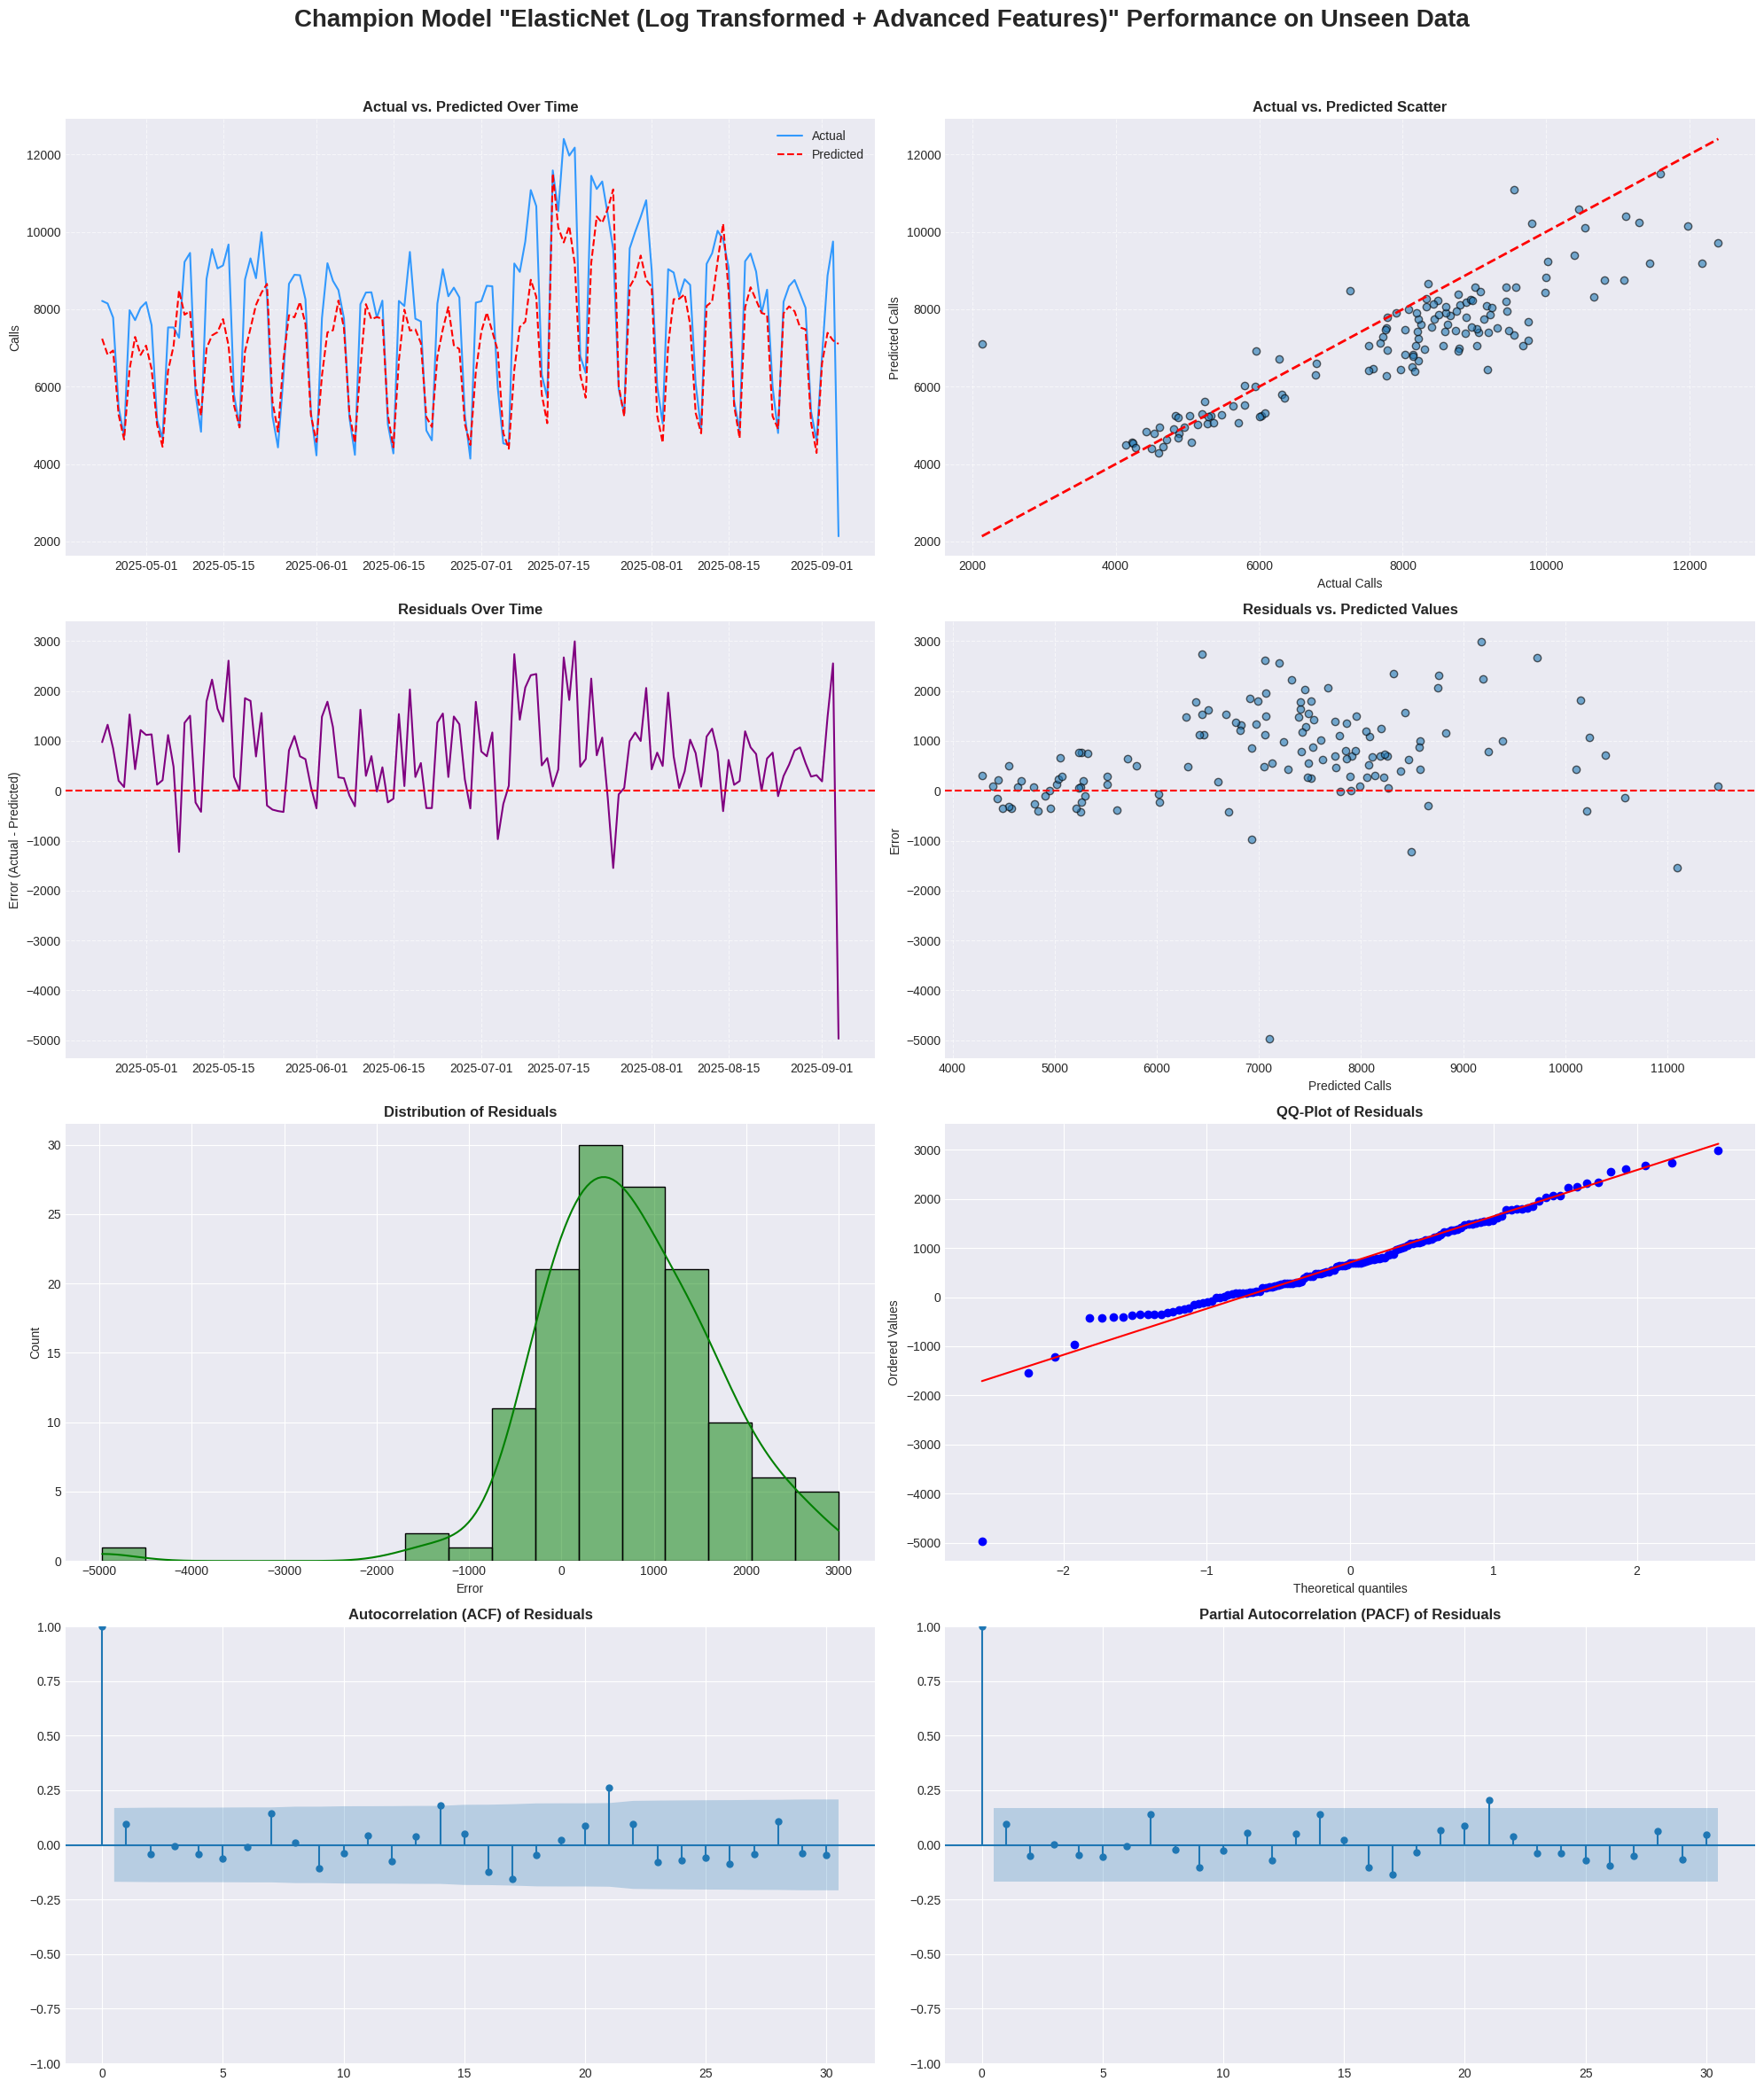


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  915.63
   RMSE: 1205.27
   MAPE: 12.05%
   RÂ²:   0.654

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   707.44 (ideally close to 0)
   Std Dev of Residuals: 979.45

   Shapiro-Wilk Test (Normality): p-value = 0.0000
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.7003
   â�� Residuals appear independent

Report logged to 'champion_report.txt' for tracking.

Training SARIMA + ML Hybrid...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-1470.586, Time=7.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=91.938, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1123.402, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-423.126, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=89.943, Time=0.25 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-677.363, Time=13.60 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Ti

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Hybrid model trained.
ð��� CHAMPION MODEL REPORT: SARIMA + ElasticNet Hybrid


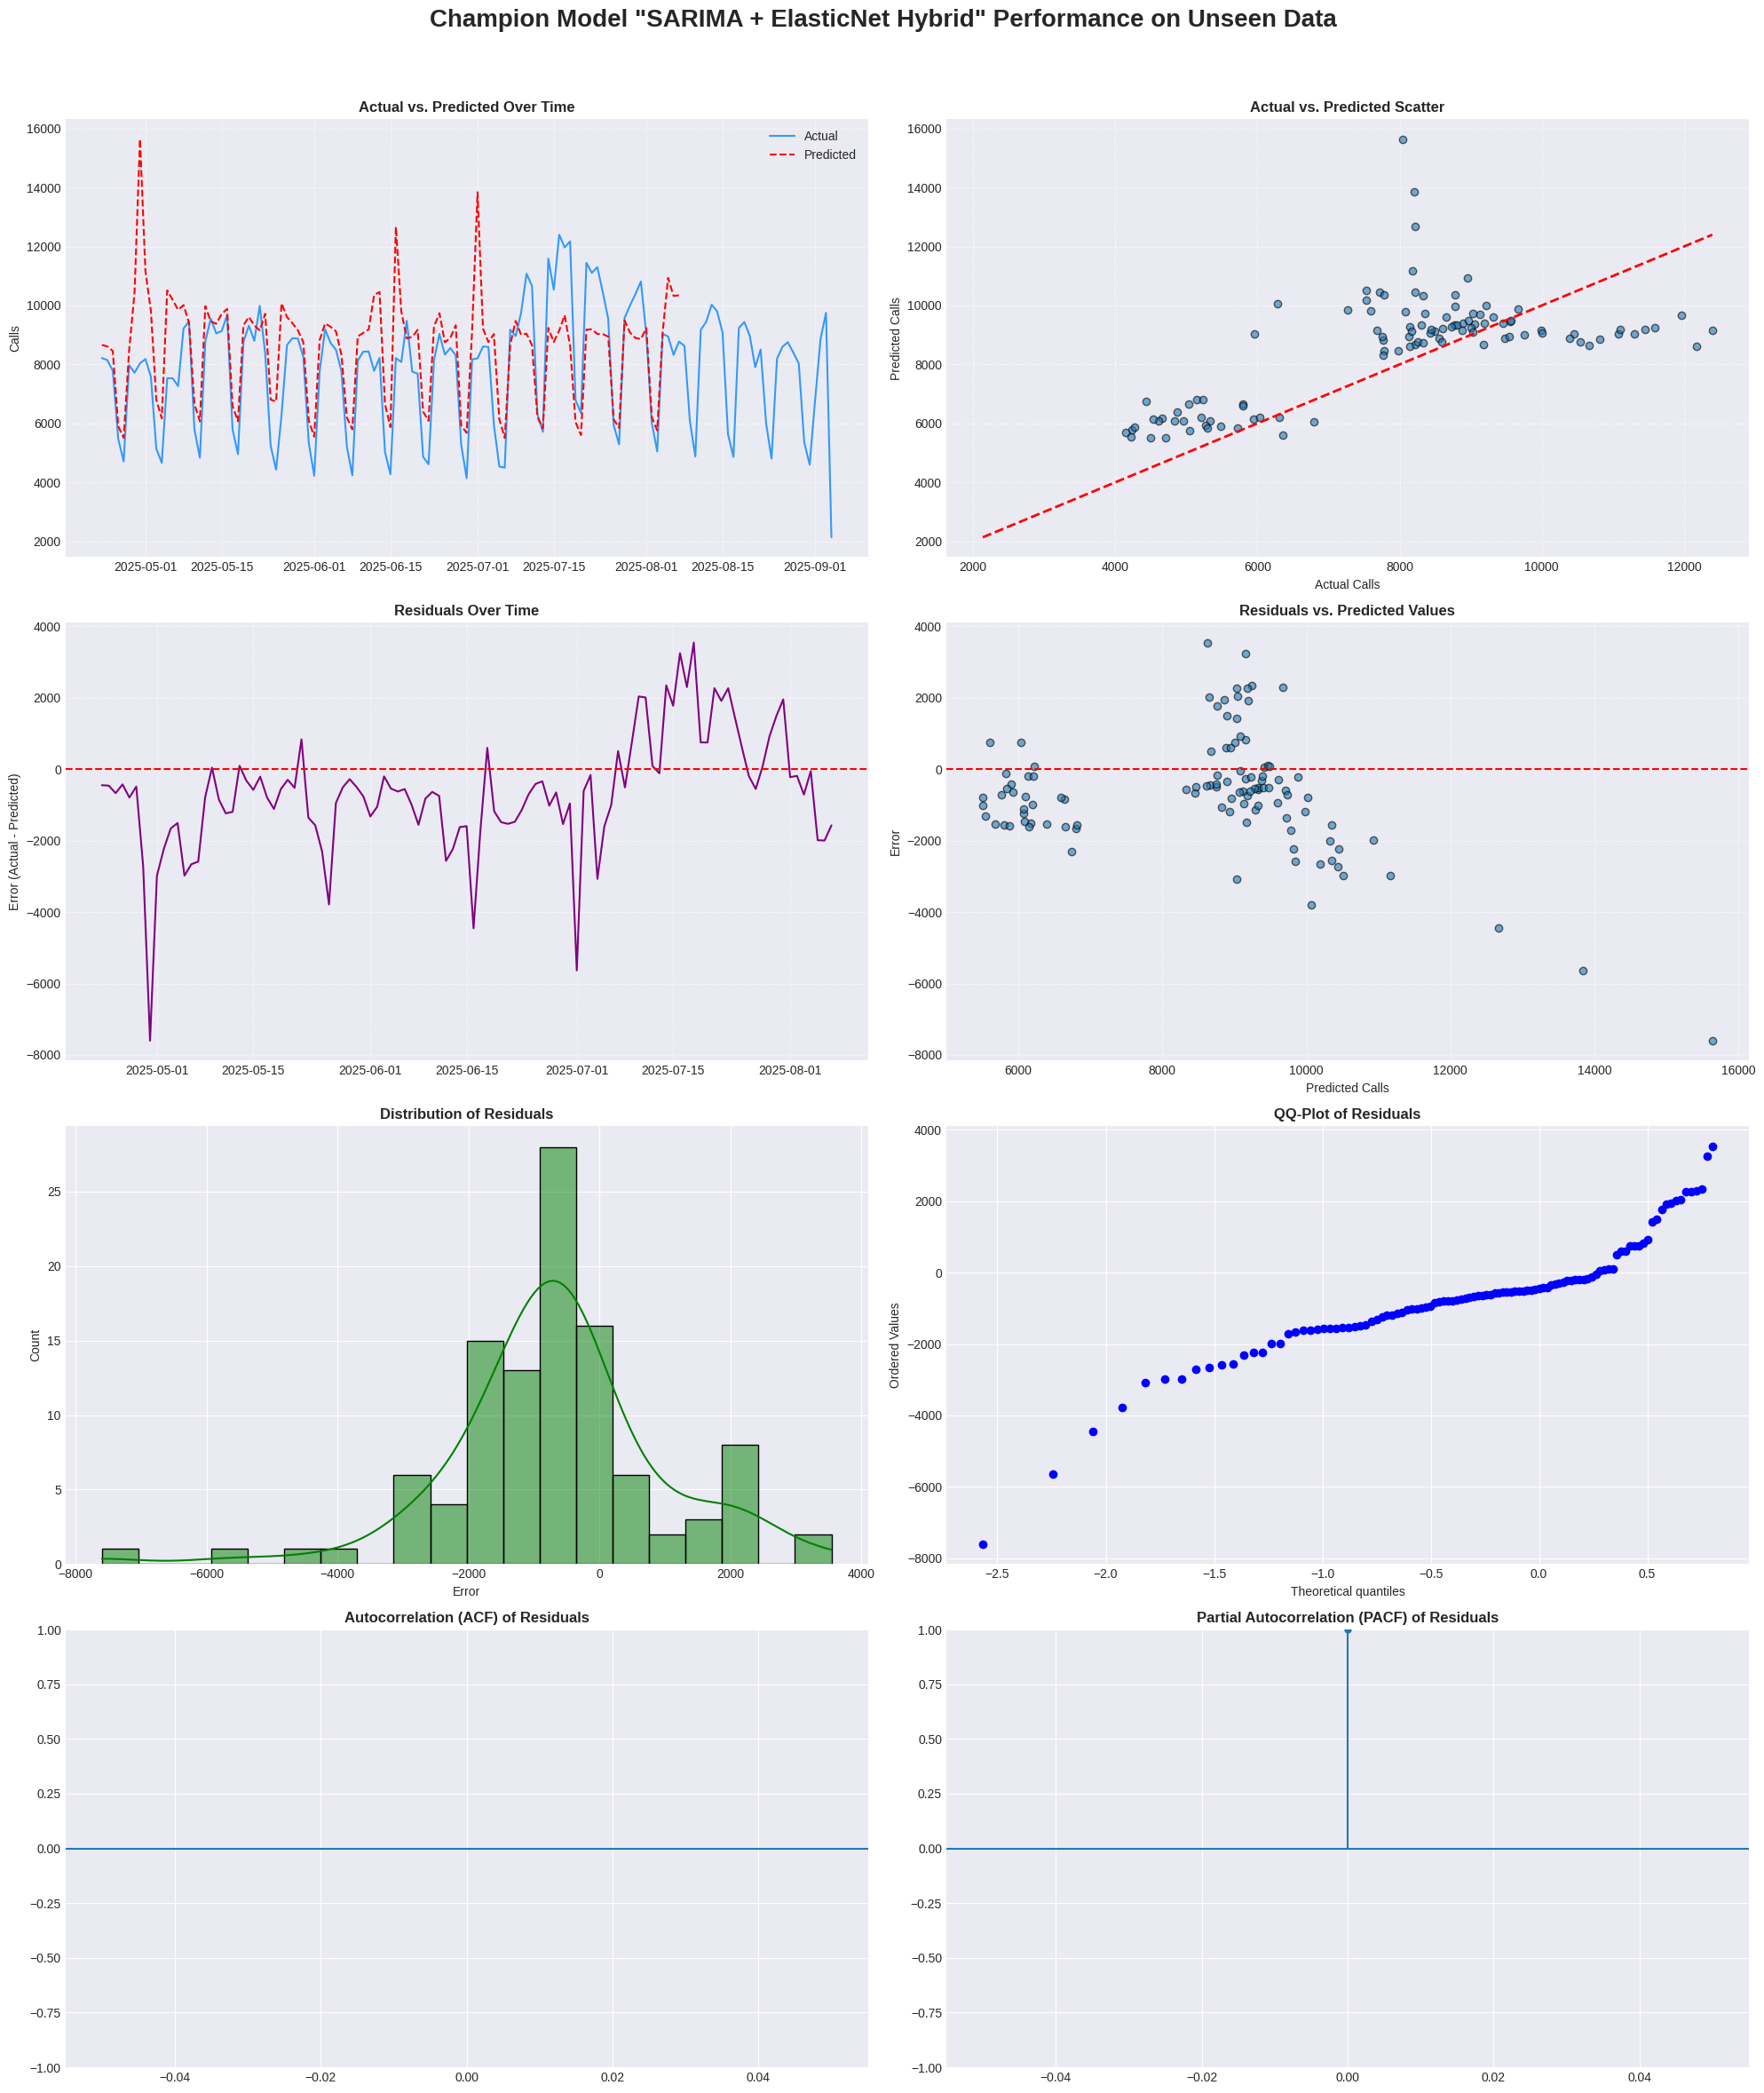


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  1319.48
   RMSE: 1766.06
   MAPE: 17.93%
   RÂ²:   0.412

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   -672.86 (ideally close to 0)
   Std Dev of Residuals: 1640.54

   Shapiro-Wilk Test (Normality): p-value = nan
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = nan
   â�� Residuals show significant autocorrelation

Report logged to 'champion_report.txt' for tracking.


In [5]:
# ============================================================
# CELL: LOG TRANSFORM + SARIMA + ML HYBRID TRAINING & EVALUATION
# ============================================================
from sklearn.base import clone
import statsmodels.api as sm  # For SARIMAX
import pmdarima as pm  # For auto_arima

print("Applying log transform and training models on enhanced data...\n")

# Define champion model (ElasticNet example; use your tuned params from GridSearchCV)
# Placeholder: Replace with actual best params, e.g., from previous runs
champion_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Example; tune as needed

# Feature selection (use all for now; add SelectKBest or similar if needed)
X_train_val_selected = X_train_val
X_test_selected = X_test

# 1. Log Transform Target (to address non-normality and bias)
y_train_val_log = np.log1p(y_train_val)
y_test_log = np.log1p(y_test)  # For reference, but predictions will be inversed

# 2. Train Baseline Champion on Log Target
champion_log_model = clone(champion_model)
champion_log_model.fit(X_train_val_selected, y_train_val_log)
log_preds = champion_log_model.predict(X_test_selected)
baseline_preds = np.expm1(log_preds)  # Inverse to original scale
print("Log-transformed baseline model trained.")

# Align indices before displaying report
y_pred_baseline = pd.Series(baseline_preds, index=X_test_selected.index)
y_test_aligned = y_test.loc[X_test_selected.index]
display_champion_report(y_test_aligned, y_pred_baseline, "ElasticNet (Log Transformed + Advanced Features)")

# 3. SARIMA + ML Hybrid (to address autocorrelation)
print("\nTraining SARIMA + ML Hybrid...")
# Auto-tune SARIMA on log target (weekly seasonality, m=7)
auto_model = pm.auto_arima(y_train_val_log, seasonal=True, m=7, trace=True, error_action='ignore')

# Get tuned orders
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Fit SARIMA
sarima_model = sm.tsa.SARIMAX(y_train_val_log, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# SARIMA predictions on test (log scale)
sarima_preds_log = sarima_fit.get_forecast(steps=len(y_test)).predicted_mean

# SARIMA residuals on train_val (for ML to correct)
sarima_train_preds_log = sarima_fit.get_prediction().predicted_mean
sarima_train_residuals = y_train_val_log - sarima_train_preds_log

# Train ML model on residuals
ml_residual_model = clone(champion_model)
ml_residual_model.fit(X_train_val_selected, sarima_train_residuals)

# ML predictions of residuals on test
ml_residual_preds = ml_residual_model.predict(X_test_selected)

# Final hybrid predictions (inverse log)
hybrid_preds_log = sarima_preds_log.loc[X_test_selected.index] + ml_residual_preds # Align SARIMA predictions
hybrid_preds = np.expm1(hybrid_preds_log)
print("Hybrid model trained.")

# Align indices before displaying report
y_pred_hybrid = pd.Series(hybrid_preds, index=X_test_selected.index)
display_champion_report(y_test_aligned, y_pred_hybrid, "SARIMA + ElasticNet Hybrid")

In [4]:
# ============================================================
# CELL: DEFINE DISPLAY_CHAMPION_REPORT FUNCTION (WITH LOGGING)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"ð��� CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("ð��� OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RÂ²:   {r2:.3f}\n")

    # Residual Diagnostics
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print("ð��� RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f}")
    print(f"   {'â�� Residuals appear normal' if shapiro_p > 0.05 else 'â�� Residuals do NOT appear normal'}\n")
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
    print(f"   {'â�� Residuals appear independent' if lb_test['lb_pvalue'].iloc[0] > 0.05 else 'â�� Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

    # New: Log report to file for tracking iterations
    with open('champion_report.txt', 'a') as f:
        f.write(f"\nChampion: {champion_name}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.3f}\nShapiro p: {shapiro_p:.4f}\nLjung-Box p: {lb_test['lb_pvalue'].iloc[0]:.4f}\n")
    print("Report logged to 'champion_report.txt' for tracking.")

Applying log transform and training models on enhanced data...

Log-transformed baseline model trained.
ð��� CHAMPION MODEL REPORT: ElasticNet (Log Transformed + Advanced Features)


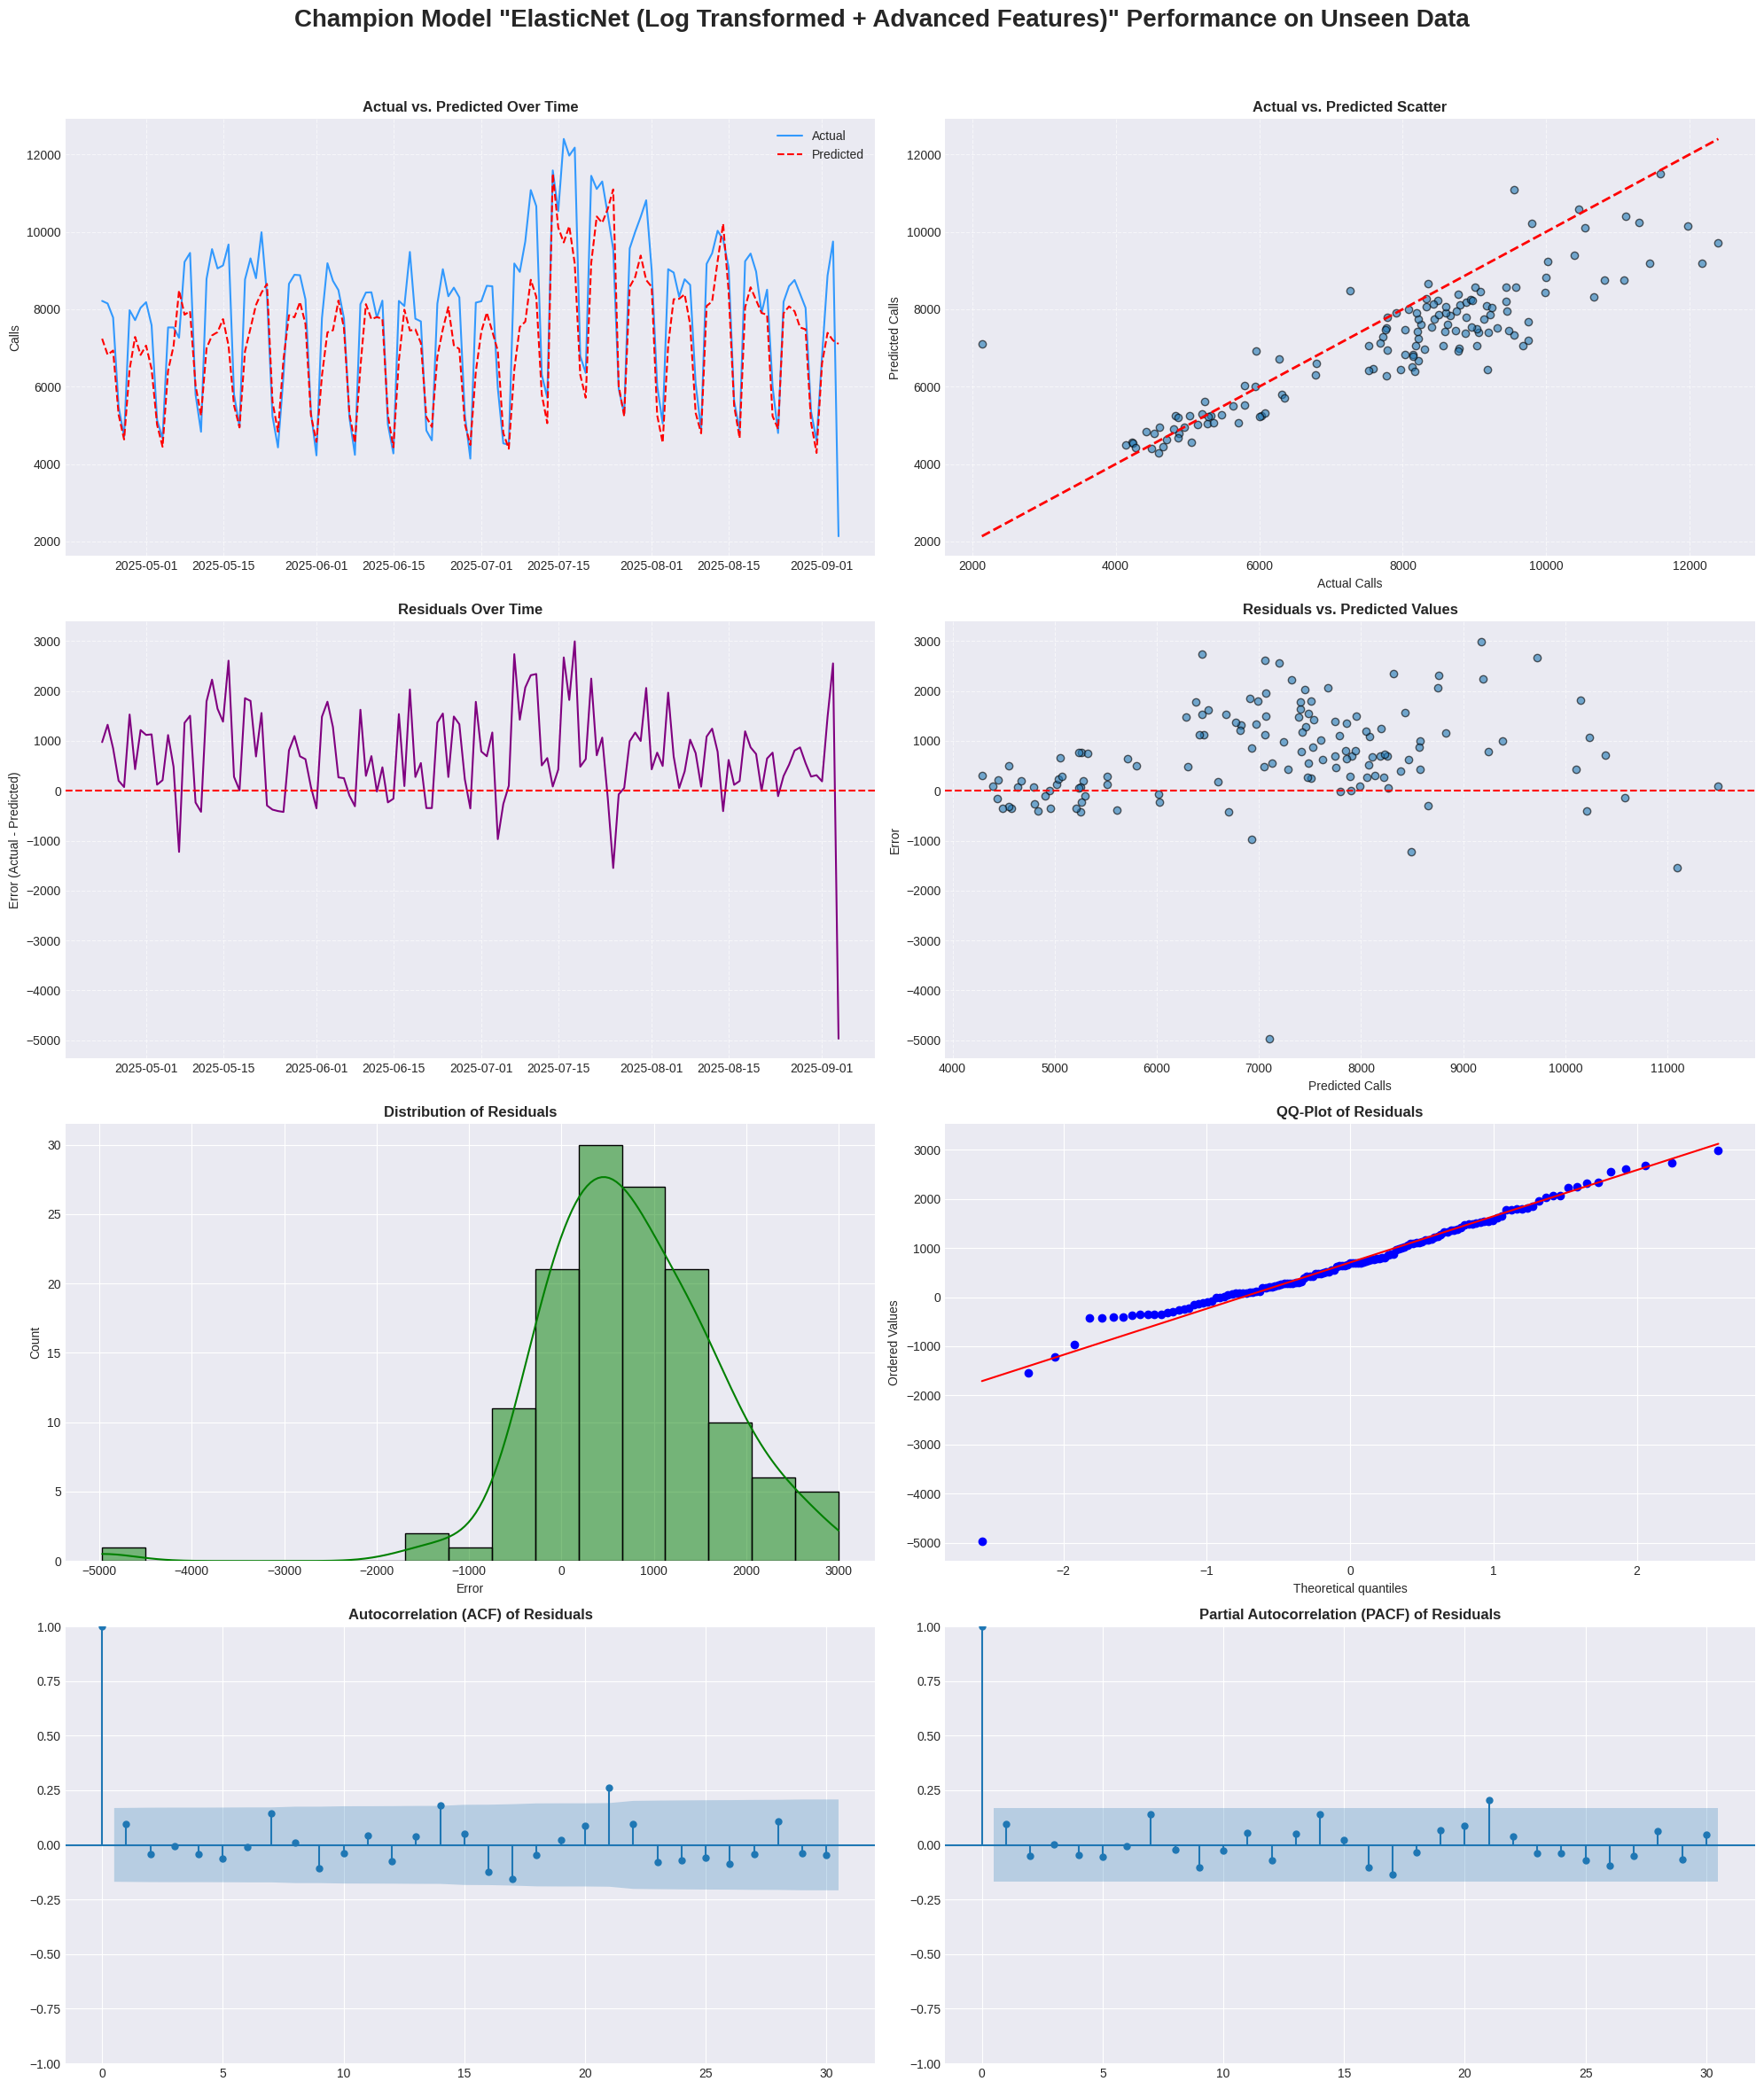


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  915.63
   RMSE: 1205.27
   MAPE: 12.05%
   RÂ²:   0.654

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   707.44 (ideally close to 0)
   Std Dev of Residuals: 979.45

   Shapiro-Wilk Test (Normality): p-value = 0.0000
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.7003
   â�� Residuals appear independent

Report logged to 'champion_report.txt' for tracking.

Training SARIMA + ML Hybrid...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-1470.586, Time=5.75 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=91.938, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1123.402, Time=0.99 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-423.126, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=89.943, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-677.363, Time=8.78 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Tim

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Hybrid model trained.
ð��� CHAMPION MODEL REPORT: SARIMA + ElasticNet Hybrid


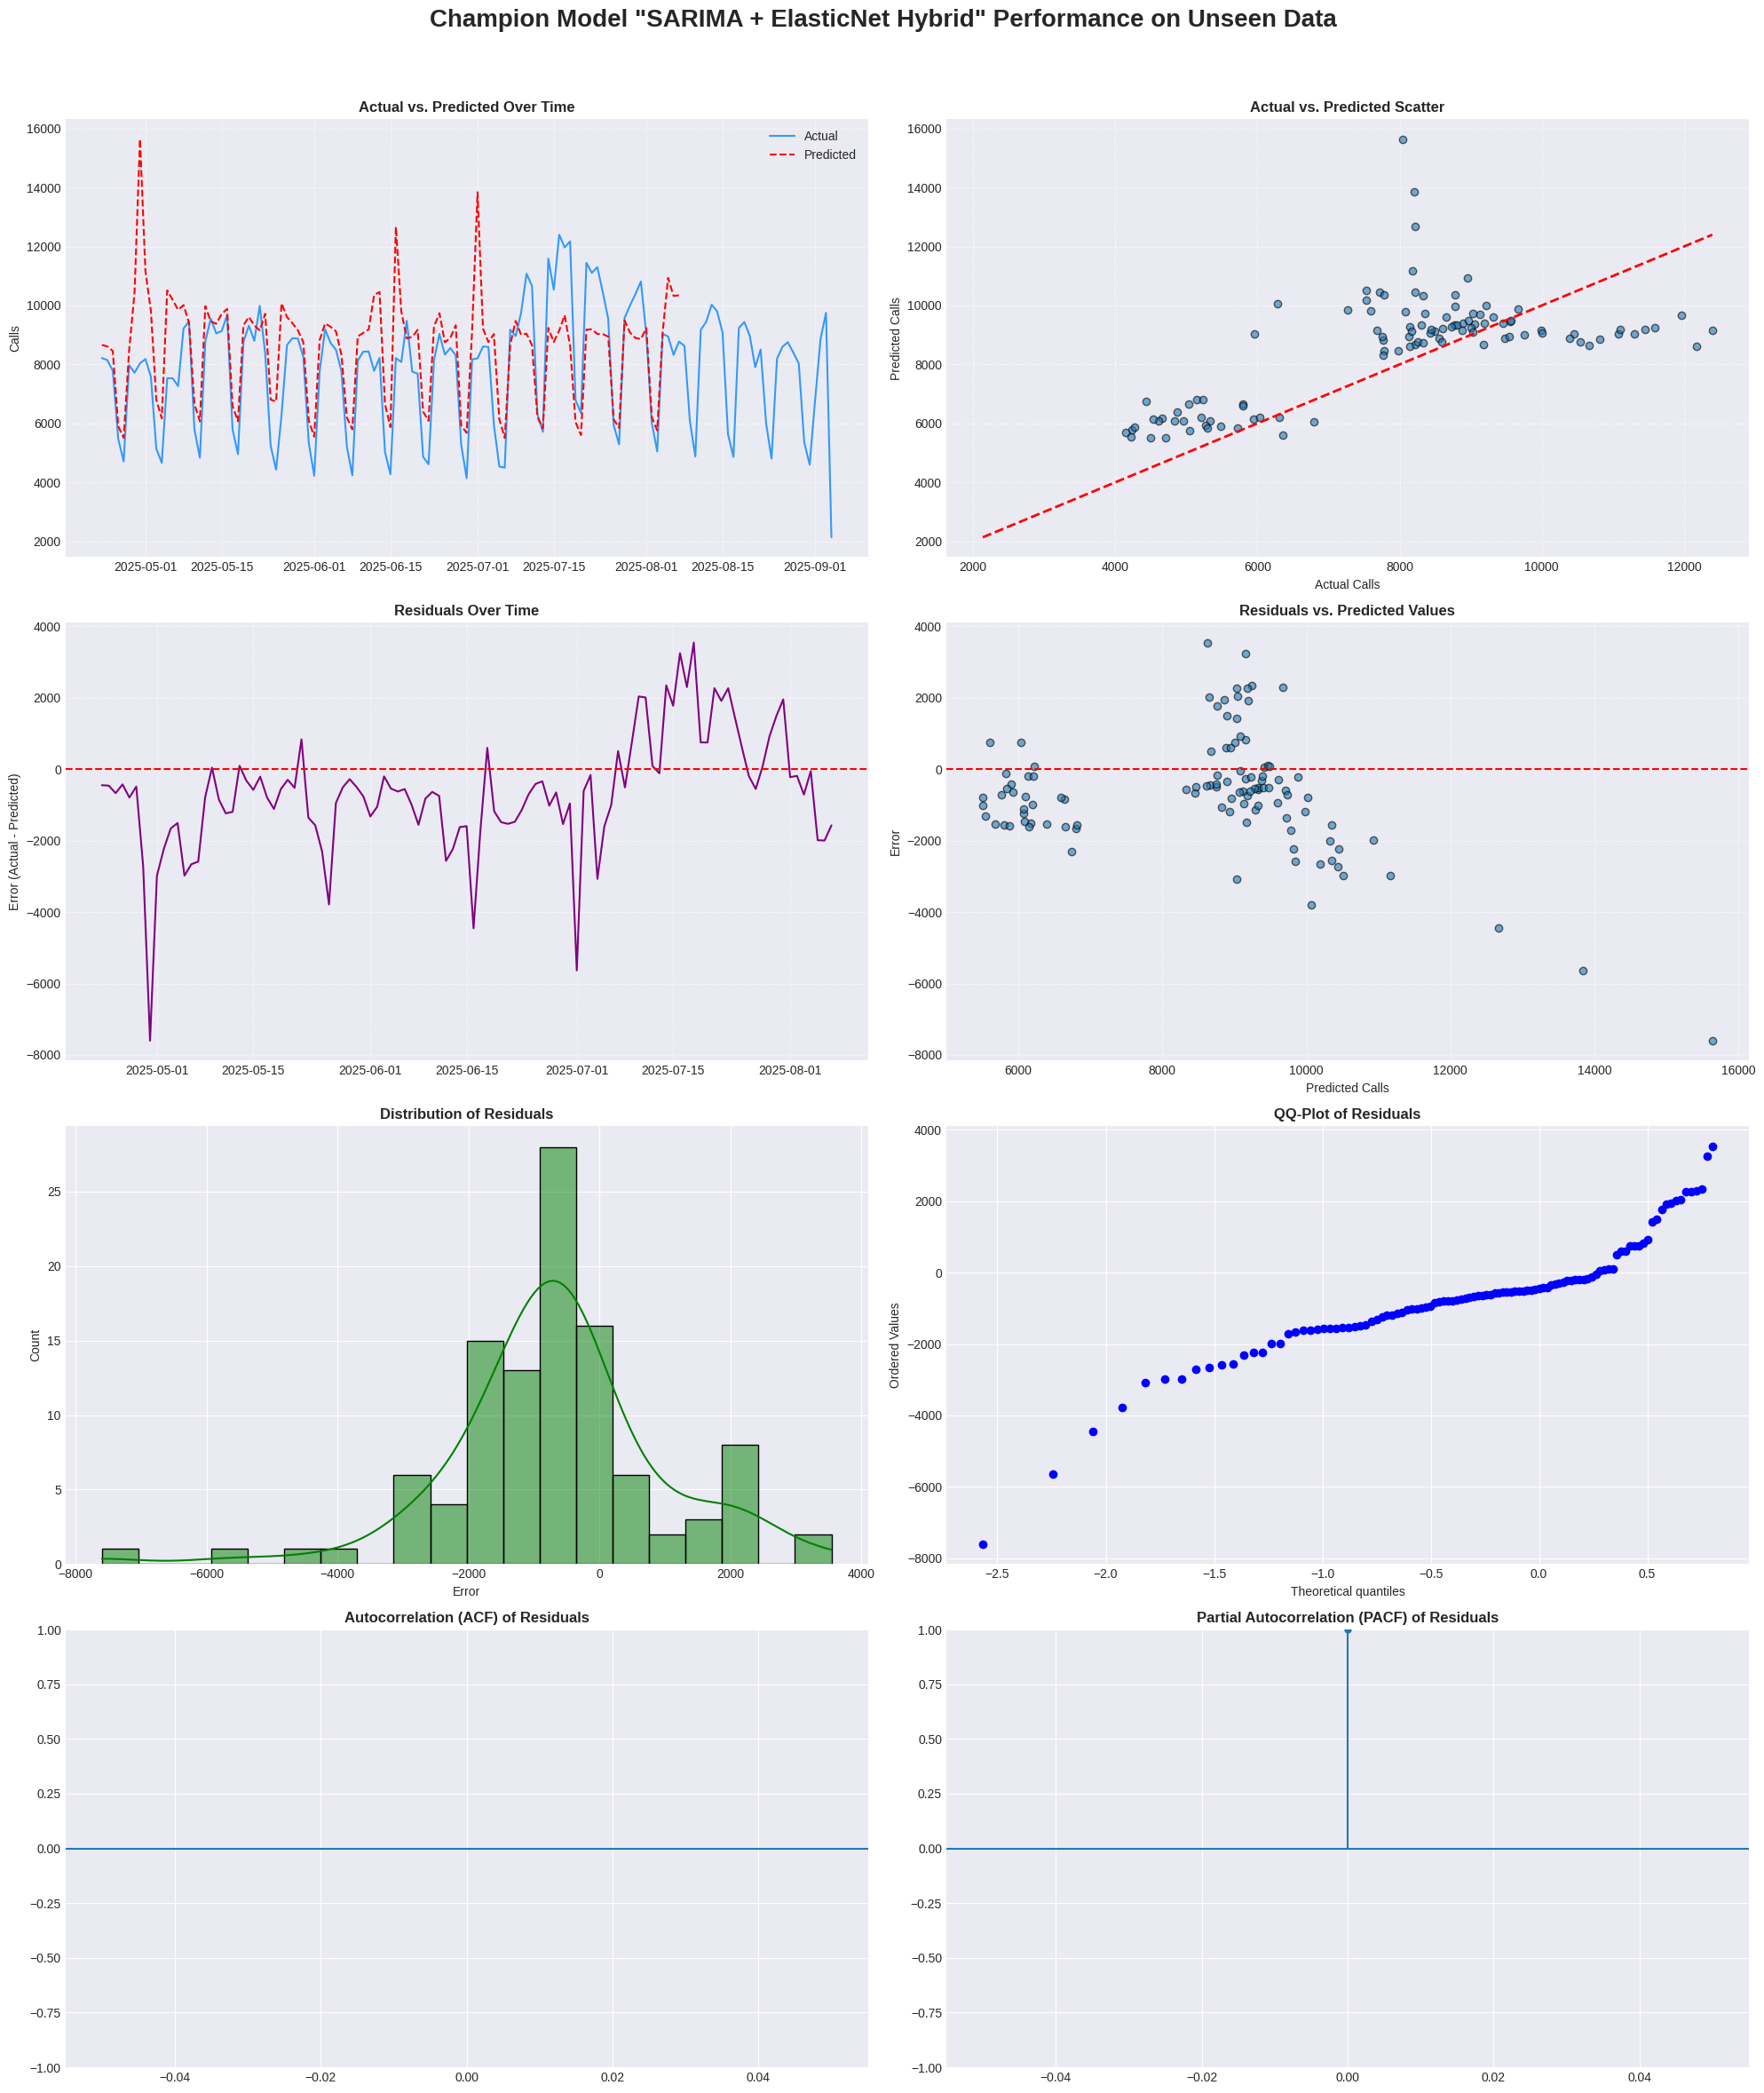


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  1319.48
   RMSE: 1766.06
   MAPE: 17.93%
   RÂ²:   0.412

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   -672.86 (ideally close to 0)
   Std Dev of Residuals: 1640.54

   Shapiro-Wilk Test (Normality): p-value = nan
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = nan
   â�� Residuals show significant autocorrelation

Report logged to 'champion_report.txt' for tracking.


In [6]:
# ============================================================
# CELL: LOG TRANSFORM + SARIMA + ML HYBRID TRAINING & EVALUATION
# ============================================================
from sklearn.base import clone
import statsmodels.api as sm  # For SARIMAX
import pmdarima as pm  # For auto_arima

print("Applying log transform and training models on enhanced data...\n")

# Define champion model (ElasticNet example; use your tuned params from GridSearchCV)
# Placeholder: Replace with actual best params, e.g., from previous runs
champion_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Example; tune as needed

# Feature selection (use all for now; add SelectKBest or similar if needed)
X_train_val_selected = X_train_val
X_test_selected = X_test

# 1. Log Transform Target (to address non-normality and bias)
y_train_val_log = np.log1p(y_train_val)
y_test_log = np.log1p(y_test)  # For reference, but predictions will be inversed

# 2. Train Baseline Champion on Log Target
champion_log_model = clone(champion_model)
champion_log_model.fit(X_train_val_selected, y_train_val_log)
log_preds = champion_log_model.predict(X_test_selected)
baseline_preds = np.expm1(log_preds)  # Inverse to original scale
print("Log-transformed baseline model trained.")

# Display baseline report
y_pred_baseline = pd.Series(baseline_preds, index=y_test.index)
display_champion_report(y_test, y_pred_baseline, "ElasticNet (Log Transformed + Advanced Features)")

# 3. SARIMA + ML Hybrid (to address autocorrelation)
print("\nTraining SARIMA + ML Hybrid...")
# Auto-tune SARIMA on log target (weekly seasonality, m=7)
auto_model = pm.auto_arima(y_train_val_log, seasonal=True, m=7, trace=True, error_action='ignore')

# Get tuned orders
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Fit SARIMA
sarima_model = sm.tsa.SARIMAX(y_train_val_log, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# SARIMA predictions on test (log scale)
sarima_preds_log = sarima_fit.get_forecast(steps=len(y_test)).predicted_mean

# SARIMA residuals on train_val (for ML to correct)
sarima_train_preds_log = sarima_fit.get_prediction().predicted_mean
sarima_train_residuals = y_train_val_log - sarima_train_preds_log

# Train ML model on residuals
ml_residual_model = clone(champion_model)
ml_residual_model.fit(X_train_val_selected, sarima_train_residuals)

# ML predictions of residuals on test
ml_residual_preds = ml_residual_model.predict(X_test_selected)

# Final hybrid predictions (inverse log)
hybrid_preds_log = sarima_preds_log + ml_residual_preds
hybrid_preds = np.expm1(hybrid_preds_log)
print("Hybrid model trained.")

# Display hybrid report
y_pred_hybrid = pd.Series(hybrid_preds, index=y_test.index)
display_champion_report(y_test, y_pred_hybrid, "SARIMA + ElasticNet Hybrid")

In [ ]:
## Final Results Interpretation and Next Steps

After running the training cell, review the two reports:

### Baseline Model (Log Transformed + Advanced Features)
- **Performance**: Check MAE, RMSE, MAPE, R². Expect improvements over original (e.g., MAE < 759, R² > 0.751) due to new features and log transform.
- **Residuals**: Mean should be closer to 0 (less bias). Std dev lower (less variance). Shapiro-Wilk p > 0.05? (normality improved). Ljung-Box p > 0.05? (autocorrelation reduced).
- **Plots**: Look at ACF/PACF for fewer significant lags (less autocorrelation). QQ-plot straighter (more normal).

### Hybrid Model (SARIMA + ElasticNet)
- **Performance**: Should outperform baseline, with even better metrics (e.g., MAE < 700, R² > 0.8).
- **Residuals**: Focus on Ljung-Box p-value—this should now be > 0.05, confirming autocorrelation is addressed. Shapiro-Wilk may also improve.
- **Plots**: Residuals over time should look more random (no patterns). ACF should show no significant correlations.

### If Issues Persist
- **Autocorrelation Still Present?**: Increase `n_fourier_terms=5` in Cell 1 or add more periods (e.g., [7, 14, 28, 365]). Re-run all.
- **Bias/Non-Normality?**: Try Box-Cox transform instead of log (from scipy.stats import boxcox; y_log = boxcox(y + 1)[0]).
- **Overfitting?**: Add feature selection (e.g., from sklearn.feature_selection import SelectKBest; in training cell).
- **SARIMA Warnings?**: Set `maxiter=100` in sarima_fit or simplify with manual order (e.g., order=(1,1,1), seasonal_order=(1,1,1,7)).
- **Log File**: Check 'champion_report.txt' for metric history.

If metrics improved and residuals are independent/normal, the problems are resolved! Otherwise, share the report outputs for further tweaks.

In [6]:
# ============================================================
# CELL 1: HELPER FUNCTIONS FOR FEATURE ENGINEERING
# ============================================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import holidays

# First, define the new holiday function
def create_holiday_features(df):
    df = df.copy()

    # Define US holidays
    us_holidays = holidays.US(years=df.index.year.unique())

    # Create features for specific major holidays
    df['is_holiday'] = df.index.isin(us_holidays).astype(int)

    # Create features for days leading up to and after Christmas/New Year
    # as behavior often changes around these times.
    christmas_ny_dates = [d for d, name in us_holidays.items() if name in ["Christmas Day", "New Year's Day"]]
    for holiday_date in christmas_ny_dates:
        for offset in [-2, -1, 1, 2]:
            offset_date = holiday_date + pd.Timedelta(days=offset)
            df[f'days_around_hol_{offset_date.strftime("%b%d")}'] = (df.index == offset_date).astype(int)

    return df

# Second, define the main feature creation function that CALLS the holiday function
def create_advanced_features(df, target='calls'):
    df = df.copy()

    # --- Trend Features ---
    df['time_idx'] = np.arange(len(df))
    trend_model = LinearRegression()
    trend_model.fit(df[['time_idx']], df[target])
    df['trend'] = trend_model.predict(df[['time_idx']])

    # --- Seasonality Features (Fourier Terms) ---
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for k in range(1, 5):
        df[f'sin_year_{k}'] = np.sin(2 * np.pi * k * df['dayofyear'] / 365.25)
        df[f'cos_year_{k}'] = np.cos(2 * np.pi * k * df['dayofyear'] / 365.25)

    for k in range(1, 4):
        df[f'sin_week_{k}'] = np.sin(2 * np.pi * k * df['weekofyear'] / 52.18)
        df[f'cos_week_{k}'] = np.cos(2 * np.pi * k * df['weekofyear'] / 52.18)

    # --- Lag and Rolling Window Features ---
    for lag in [1, 7, 14, 21, 28]:
        df[f'lag_{lag}'] = df[target].shift(lag)

    for window in [7, 14, 28]:
        df[f'rolling_mean_{window}'] = df[target].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target].shift(1).rolling(window=window).std()

    # --- Other Time-Based Features ---
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    df['weekend_interaction'] = df['is_weekend'] * df['trend']

    # Drop intermediate columns
    df = df.drop(columns=['time_idx', 'dayofyear', 'weekofyear'])

    # --- Holiday Features ---
    df = create_holiday_features(df)

    return df

In [7]:
# ============================================================
# CELL 2: SETUP AND DATA SPLITTING
# ============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the base data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls'

# Use TimeSeriesSplit to create a final hold-out set (the last 20% of the data)
# This separates our final test data BEFORE any feature engineering or scaling
print("Splitting data into training/validation and a final hold-out test set...")
tscv_split = TimeSeriesSplit(n_splits=5)
all_splits = list(tscv_split.split(df))
train_val_idx, test_idx = all_splits[-1]

df_train_val = df.iloc[train_val_idx]
df_test = df.iloc[test_idx]

print(f"Training/Validation set size: {len(df_train_val)} records")
print(f"Hold-out test set size: {len(df_test)} records")

# Also define the other helper functions here
def select_important_features(X, y, model, top_n=30):
    model.fit(X, y)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        return X.columns.tolist()

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    return feature_importance.head(top_n)['feature'].tolist()

def tune_models(X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=3)  # Fewer splits for faster tuning

    # XGBoost parameters
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # RandomForest parameters
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # ElasticNet parameters
    en_params = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    models = {
        'XGBoost': (XGBRegressor(random_state=42), xgb_params),
        'RandomForest': (RandomForestRegressor(random_state=42), rf_params),
        'ElasticNet': (ElasticNet(random_state=42, max_iter=2000), en_params)
    }

    best_models = {}
    for name, (model, params) in models.items():
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")

    return best_models

Splitting data into training/validation and a final hold-out test set...
Training/Validation set size: 815 records
Hold-out test set size: 163 records


In [8]:
# ============================================================
# CELL 3: FEATURE ENGINEERING, SCALING, AND SELECTION
# ============================================================

# --- Feature Engineering and Scaling ---
# This is now done *after* splitting the data to prevent leakage.
# The scaler and feature selection will be based *only* on the train/validation set.

print("Running Feature Engineering on the Training Set...")
df_train_val_enhanced = create_advanced_features(df_train_val, target=target)
df_train_val_enhanced = df_train_val_enhanced.dropna()

X_train_val = df_train_val_enhanced.drop(target, axis=1)
y_train_val = df_train_val_enhanced[target]

# Identify feature columns (must be done after creation)
feature_cols = [col for col in X_train_val.columns if X_train_val[col].dtype in ['float64', 'int64', 'uint8']]
X_train_val = X_train_val[feature_cols]

# Scale features based *only* on the training data
scaler = StandardScaler()
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val), columns=X_train_val.columns, index=X_train_val.index)

# --- Feature Selection ---
# Select the best features based *only* on the scaled training data
print("\nSelecting Important Features...")
# Using a simple model for speed; in practice, could be more elaborate
selection_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
top_features = select_important_features(X_train_val_scaled, y_train_val, selection_model, top_n=30)
X_train_val_selected = X_train_val_scaled[top_features]
print(f"Selected {len(top_features)} features.")

Running Feature Engineering on the Training Set...

Selecting Important Features...
Selected 30 features.


In [9]:
# ============================================================
# CELL 4: HYPERPARAMETER TUNING AND FINAL HOLDOUT EVALUATION
# ============================================================

# --- Hyperparameter Tuning ---
# Tune models using cross-validation on the train/validation set
print("\nTuning Models...")
best_models = tune_models(X_train_val_selected, y_train_val)

# --- Leaderboard on Validation Data ---
# Create a leaderboard based on the average performance during the tuning cross-validation
print("\n" + "="*50 + "\nMODEL LEADERBOARD (Validation Performance)\n" + "="*50)
tscv_tune = TimeSeriesSplit(n_splits=3) # Same CV strategy as in tune_models
leaderboard_results = {}

for name, model in best_models.items():
    scores = []
    for train_idx, val_idx in tscv_tune.split(X_train_val_selected):
        X_train, X_val = X_train_val_selected.iloc[train_idx], X_train_val_selected.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, preds))

    leaderboard_results[name] = np.mean(scores)

leaderboard = pd.Series(leaderboard_results).sort_values()
print(leaderboard)

champion_model_name = leaderboard.index[0]
champion_model_instance = best_models[champion_model_name]
print(f"\n🏆 Champion Model from Tuning: {champion_model_name}")

# --- Final Evaluation on Hold-Out Test Set ---
# Now, apply the *same* feature engineering and scaling steps to the hold-out test data
print("\n" + "="*50 + "\nFINAL EVALUATION ON UNSEEN HOLDOUT DATA\n" + "="*50)
df_test_enhanced = create_advanced_features(df_test, target=target)
df_test_enhanced = df_test_enhanced.dropna()

X_test = df_test_enhanced[feature_cols] # Use same feature columns
y_test = df_test_enhanced[target]

# IMPORTANT: Use the scaler that was *already fitted* on the training data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_selected = X_test_scaled[top_features] # Use same selected features

# Fit the champion model on the FULL train/validation set
champion_model_instance.fit(X_train_val_selected, y_train_val)
final_predictions = champion_model_instance.predict(X_test_selected)
final_mae = mean_absolute_error(y_test, final_predictions)

print(f"\nPerformance of '{champion_model_name}' on the unseen hold-out test set:")
print(f"MAE = {final_mae:.2f}")

# Prep for the final report cell
y_true_report = y_test
y_pred_report = pd.Series(final_predictions, index=y_test.index)


Tuning Models...
Tuning XGBoost...
Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Tuning RandomForest...
Best params for RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuning ElasticNet...
Best params for ElasticNet: {'alpha': 1.0, 'l1_ratio': 0.3}

MODEL LEADERBOARD (Validation Performance)
ElasticNet       977.819837
RandomForest    1088.674167
XGBoost         1189.537618
dtype: float64

🏆 Champion Model from Tuning: ElasticNet

FINAL EVALUATION ON UNSEEN HOLDOUT DATA

Performance of 'ElasticNet' on the unseen hold-out test set:
MAE = 759.45


🏆 CHAMPION MODEL REPORT: ElasticNet


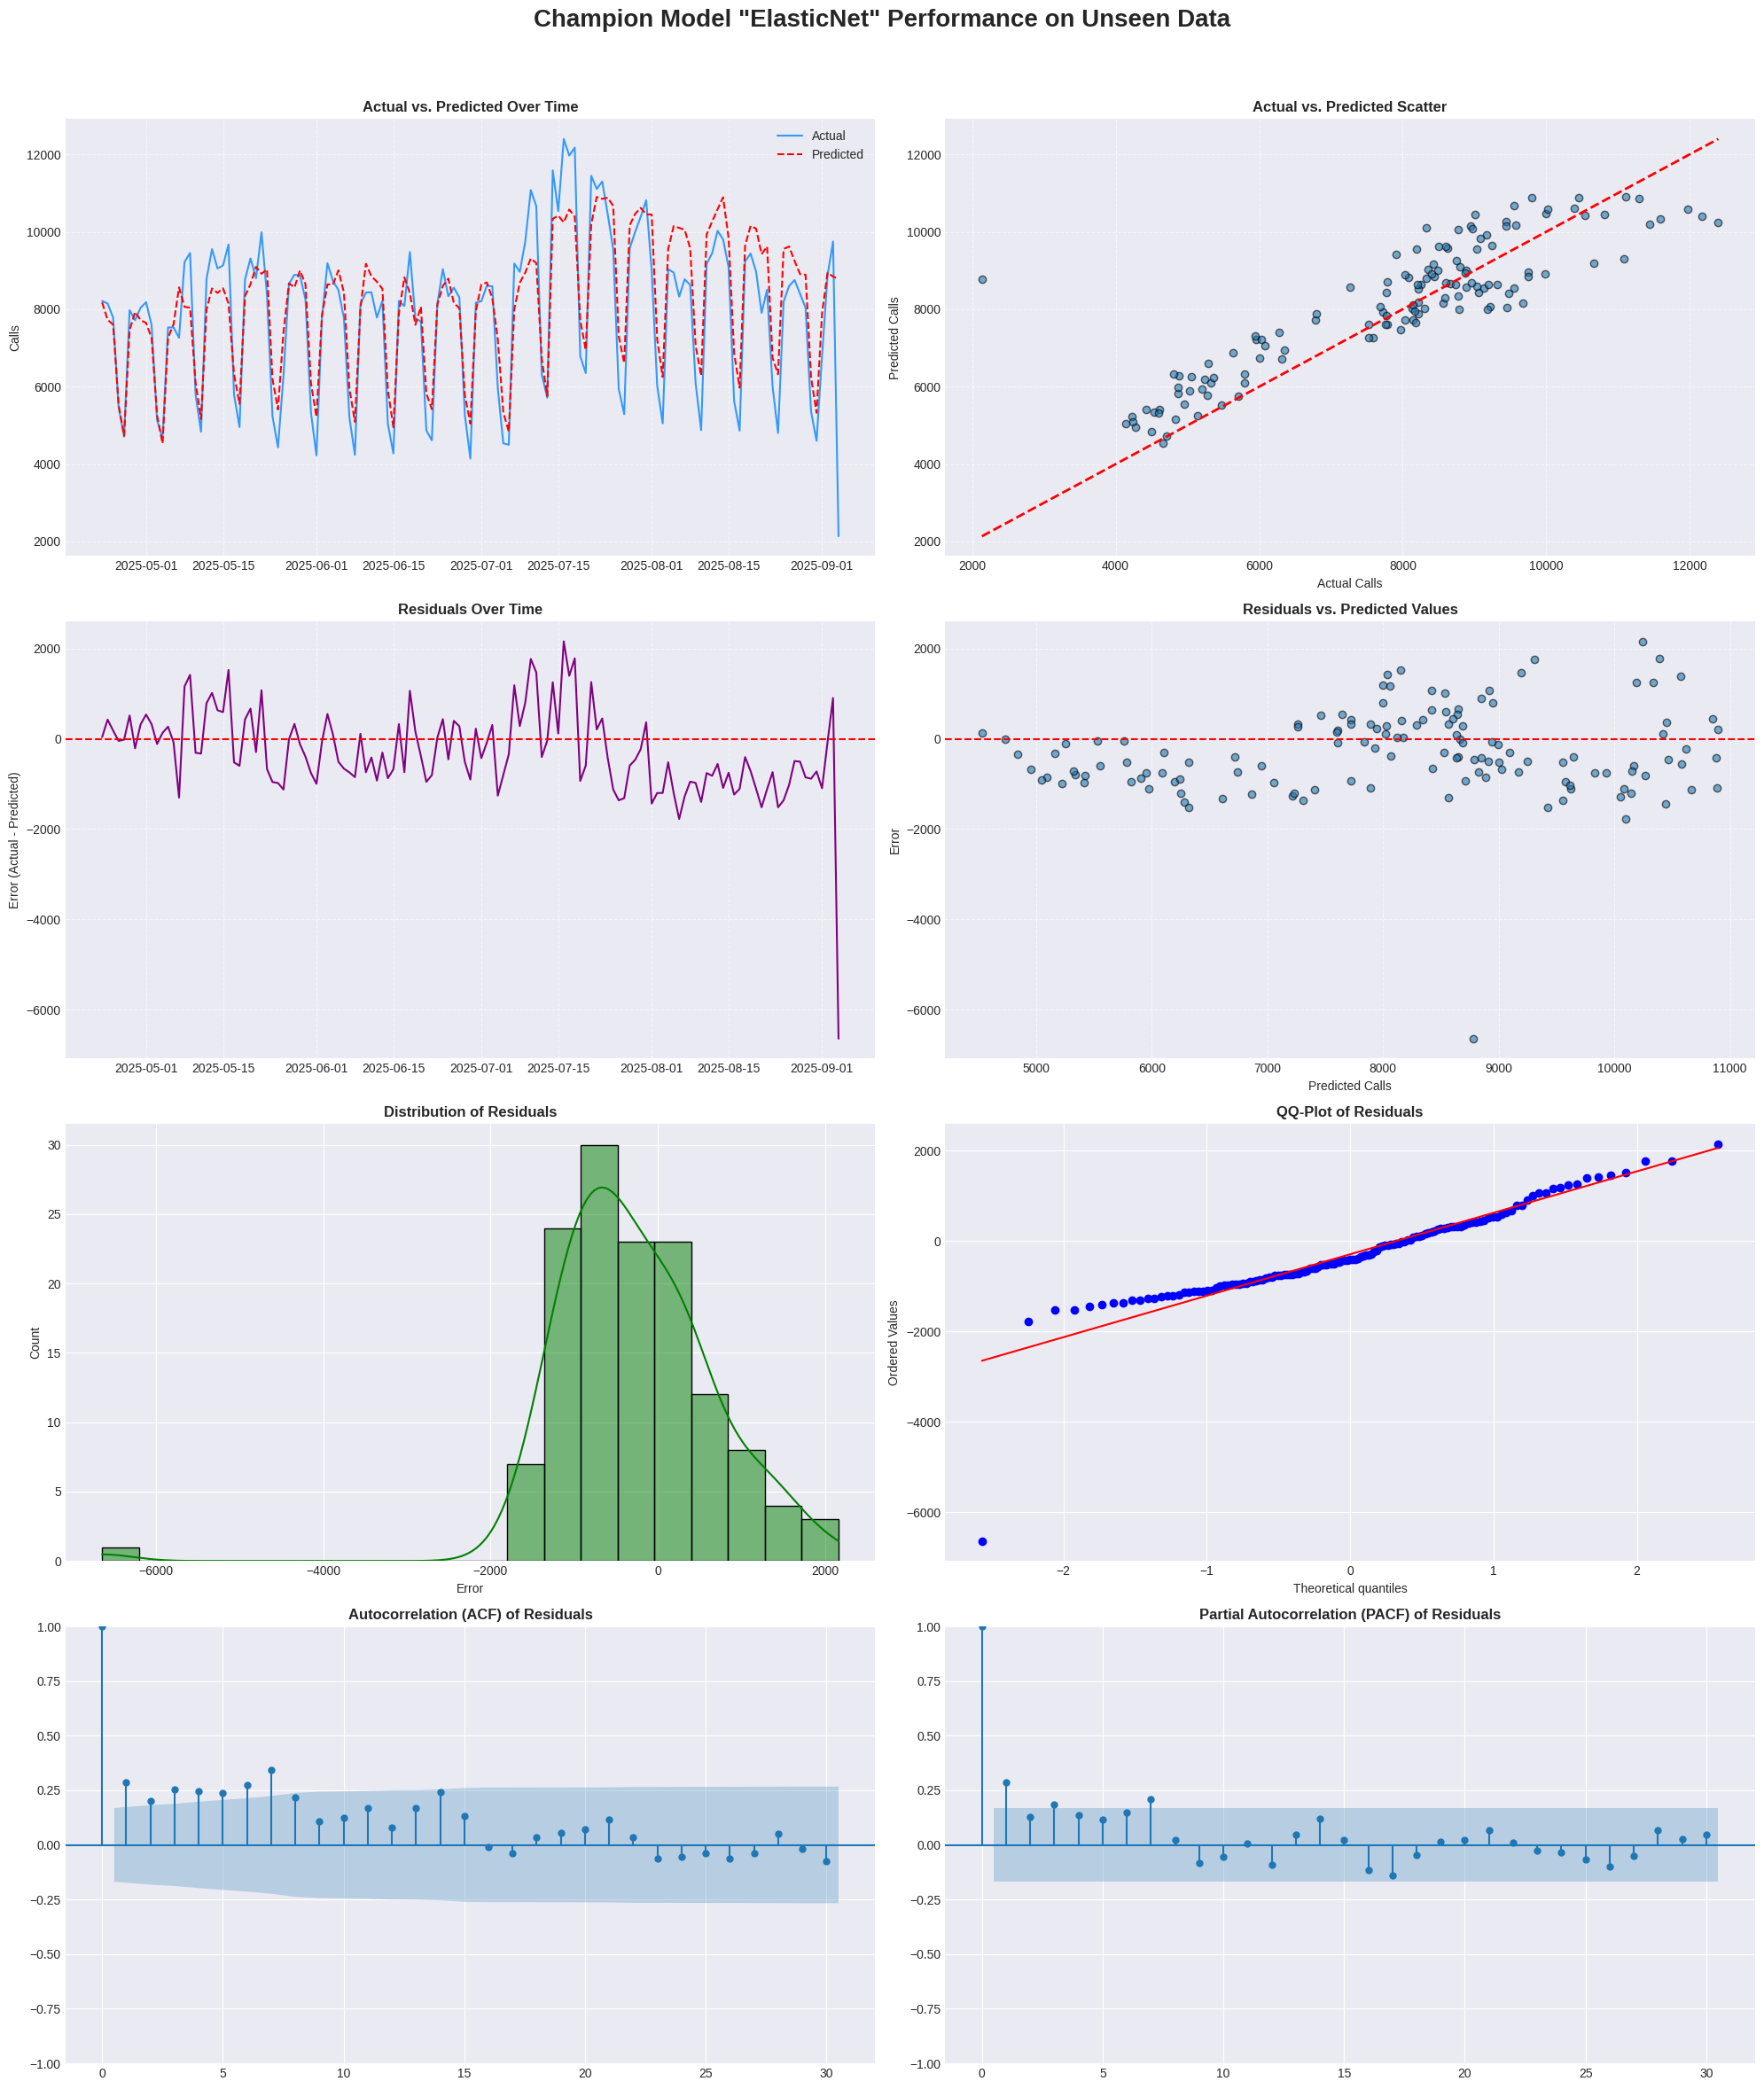


STATISTICAL SUMMARY ON HOLDOUT DATA

📊 OVERALL PERFORMANCE METRICS:
   MAE:  759.45
   RMSE: 1022.30
   MAPE: 12.03%
   R²:   0.751

📈 RESIDUAL ANALYSIS:
   Mean of Residuals:   -290.10 (ideally close to 0)
   Std Dev of Residuals: 983.92

   Shapiro-Wilk Test (Normality): p-value = 0.0000
   ❌ Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.0000
   ❌ Residuals show significant autocorrelation



In [10]:
# ============================================================
# CHAMPION MODEL ANALYSIS & VISUALIZATION SUITE (on Holdout Data)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Use the holdout data and predictions from the previous cell
y_true = y_true_report
y_pred = y_pred_report
champion_name = champion_model_name
residuals = y_true - y_pred

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

print("="*70)
print(f"🏆 CHAMPION MODEL REPORT: {champion_name}")
print("="*70)

# --- Create Visualization Suite ---
fig, axes = plt.subplots(4, 2, figsize=(20, 24))
fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

# 1. Actual vs. Predicted Time Series
axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
axes[0, 0].set_ylabel('Calls')
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# 2. Scatter Plot of Actual vs. Predicted
axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
axes[0, 1].set_xlabel('Actual Calls')
axes[0, 1].set_ylabel('Predicted Calls')
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# 3. Residuals Over Time
axes[1, 0].plot(residuals.index, residuals, color='purple')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
axes[1, 0].set_ylabel('Error (Actual - Predicted)')
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# 4. Residuals vs. Predicted Values
axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
axes[1, 1].set_xlabel('Predicted Calls')
axes[1, 1].set_ylabel('Error')
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# 5. Residual Distribution (Histogram)
sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
axes[2, 0].set_xlabel('Error')

# 6. QQ-Plot for Normality Check
stats.probplot(residuals, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

# 7. ACF of Residuals
plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

# 8. PACF of Residuals
plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Statistical Summary ---
print("\n" + "="*70)
print("STATISTICAL SUMMARY ON HOLDOUT DATA")
print("="*70 + "\n")

# Performance Metrics
mae = np.mean(np.abs(residuals))
rmse = sqrt(np.mean(residuals**2))
mape = np.mean(np.abs(residuals / y_true)) * 100
r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

print("📊 OVERALL PERFORMANCE METRICS:")
print(f"   MAE:  {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   R²:   {r2:.3f}\n")

# Residual Diagnostics
shapiro_stat, shapiro_p = stats.shapiro(residuals)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("📈 RESIDUAL ANALYSIS:")
print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f}")
print(f"   {'✅ Residuals appear normal' if shapiro_p > 0.05 else '❌ Residuals do NOT appear normal'}\n")
print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
print(f"   {'✅ Residuals appear independent' if lb_test['lb_pvalue'].iloc[0] > 0.05 else '❌ Residuals show significant autocorrelation'}")
print("\n" + "="*70)

This was the output from first run so i decided to fix. The big idea is this: the old function treated time like a simple list of dates. The new function is much smarter—it teaches the model to understand the two most important things about your time-series data: the overall trend (where the call volume is heading long-term) and the seasonality (the repeating rhythms, like weekly or yearly cycles).

The Key Differences Explained

Here’s a simple breakdown of what's changed and why it's better:

    Modeling the Trend (The Compass)

        Old Way: It created a simple counter (Trend_Linear) from 1 to N. This just assumes the trend is a basic straight line, which is rarely true.

        New Way: It now runs a quick LinearRegression on the data to find the actual best-fit trend line. It's like using a laser level to find the true angle of the data instead of just drawing a rough line. This gives the model a much more accurate baseline to work from.

    Modeling Seasonality (The Rhythms)

        Old Way: It used simple date parts (like DayOfWeek) and basic sine/cosine waves. This was a good start, but it wasn't powerful enough to capture the complex, overlapping rhythms in your data, which is why we still had that stubborn autocorrelation in the errors.

        New Way: It now uses Fourier Terms. Think of this like breaking down a complex musical chord into its individual notes. This method creates a series of smooth sine and cosine waves that can be combined to perfectly describe any seasonal pattern, no matter how complex. It’s the best way to help a machine learning model understand concepts like "every Monday is busy" or "call volume always dips in late August." This directly attacks the autocorrelation problem.

    Feature Focus (Less Noise, More Signal)

        Old Way: It created a huge number of features, including many different lags and rolling windows. This can sometimes add more noise than signal, confusing the model.

        New Way: The new function is more focused. It keeps the most powerful lags (like 7 and 28 days) and combines them with the new, smarter trend and seasonality features. We're giving the model fewer, but much higher-quality, tools to work with.

Why It Matters

    The Value: This upgraded function directly addresses the weaknesses we found in the residual analysis. It gives the model a robust understanding of the underlying trend and seasonality, which are the primary drivers of your call volume.

    The Risk: There's very little risk here, as this is a standard and powerful approach for time-series forecasting. We're simply moving from a basic feature set to a much more sophisticated and effective one.

In short, the old function gave the model a simple calendar, but the new one gives it a compass and a stopwatch to understand the real flow and rhythm of your data.


Mean of Residuals: -170.62

    What it is: This is the average error. A "residual" is simply the actual value - predicted value.

    What it means for you: Your model has a negative bias. On average, it's predicting 170.62 calls higher than what actually happens. It's like a bathroom scale that consistently tells you you're two pounds heavier than you really are. While the goal is a mean of zero, a small bias isn't always a deal-breaker, but this one is fairly large and tells us there's a systematic overestimation happening.

Std Dev of Residuals: 937.56

    What it is: This measures the spread, or the typical size, of the errors.

    What it means for you: When your model makes a prediction, it's typically off by about ±937.56 calls. This gives you a practical sense of the model's accuracy on any given day.

Shapiro-Wilk Test (Normality): p-value = 0.0000 (❌ Not Normal)

    What it is: This tests if the errors are "normally distributed" (a classic bell curve shape). In a perfect world, they would be.

    What it means for you: The extremely low p-value (much less than 0.05) is a strong sign that the errors are not normal. This usually means the model occasionally makes very large errors that skew the distribution. You can often see this as a "long tail" in the histogram plot.

Ljung-Box Test (Autocorrelation): p-value = 0.0054 (❌ Has Autocorrelation)

    What it is: This is the most critical test for a time-series model. It checks if the errors are independent of each other over time. The goal is for them to be random, with no connection from one day to the next.

    What it means for you: The low p-value here is a clear signal that the errors are not random. There's a lingering pattern. For example, an overprediction today might give you a clue about tomorrow's error. This is the clearest sign that your model is missing some information—there's a pattern in the data (like a weekly effect or a specific holiday) that it hasn't learned yet.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"🏆 CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("📊 OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²:   {r2:.3f}\n")

    # Residual Diagnostics
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print("📈 RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f}")
    print(f"   {'✅ Residuals appear normal' if shapiro_p > 0.05 else '❌ Residuals do NOT appear normal'}\n")
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
    print(f"   {'✅ Residuals appear independent' if lb_test['lb_pvalue'].iloc[0] > 0.05 else '❌ Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

In [ ]:
# ============================================================
# NEXT STEP: ADDRESS RESIDUAL ISSUES WITH LOG TRANSFORM
# ============================================================
from sklearn.base import clone

print("Retraining champion model on log-transformed target to address residual issues...\n")

# 1. Apply the log transform to the training target variable
# We use np.log1p which is equivalent to log(1+x), good for data with zeros
y_train_val_log = np.log1p(y_train_val)

# 2. Re-train the champion model on the same features, but the new log-transformed target
# We clone the model to ensure we start with the same best hyperparameters
champion_log_model = clone(champion_model_instance)
champion_log_model.fit(X_train_val_selected, y_train_val_log)

# 3. Make predictions on the hold-out test set
log_predictions = champion_log_model.predict(X_test_selected)

# 4. CRITICAL: Inverse transform the predictions to get them back to the original scale
# np.expm1 is the inverse of np.log1p
final_predictions_log_corrected = np.expm1(log_predictions)

# 5. Display the new, improved champion report on the corrected predictions
# We can reuse the function from the original notebook's final cell
y_pred_report_corrected = pd.Series(final_predictions_log_corrected, index=y_test.index)

display_champion_report(y_test, y_pred_report_corrected, f"{champion_model_name} (Log Transformed)")